# Multi-Class Text Classification with Scikit-Learn using TF-IDF model

### 1. Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import plotly
import plotly.express as px

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### 2. Load and Explore the Dataset
For text classification, you can use any labeled dataset. Here, let's consider using a dataset like the 20 Newsgroups dataset available in Scikit-Learn.

##### DataSet1 - Twitter Sample

In [2]:
# import nltk
# from nltk.corpus import twitter_samples

# # nltk.download('twitter_samples')

# # Load positive tweets
# positive_tweets = twitter_samples.raw('positive_tweets.json')

# # Load negative tweets
# negative_tweets = twitter_samples.raw('negative_tweets.json')

# # Load a general tweet file (can be a mix of positive and negative)
# all_tweets = twitter_samples.raw('tweets.20150430-223406.json')

# def load_json_lines(json_data):
#     tweets = []
#     for line in json_data.splitlines():
#         if line.strip():  # Skip empty lines
#             tweets.append(json.loads(line))
#     return tweets

# # Load and parse the tweets data
# positive_tweets_list = load_json_lines(positive_tweets)
# negative_tweets_list = load_json_lines(negative_tweets)

# # Convert to DataFrames
# positive_df = pd.DataFrame(positive_tweets_list)
# negative_df = pd.DataFrame(negative_tweets_list)

# # Add labels
# positive_df['label'] = 'positive'
# negative_df['label'] = 'negative'

# # Combine into a single DataFrame
# df = pd.concat([positive_df, negative_df], ignore_index=True)

# print(df[['text', 'label']]['text'].head()[0])
# print(df[['text', 'label']]['label'].head()[0])

##### Dataset2 - newsgroups

In [3]:
from sklearn.datasets import fetch_20newsgroups

# Load dataset
newsgroups = fetch_20newsgroups(subset='train', categories=['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian'])
data = newsgroups.data
target = newsgroups.target

# Create a DataFrame
df = pd.DataFrame({'text': data, 'label': target})

# Display first few rows
df.head()

,text,label
0,From: sd345@city.ac.uk (Michael Collier)\nSubj...,1
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\...,1
2,From: djohnson@cs.ucsd.edu (Darin Johnson)\nSu...,3
3,From: s0612596@let.rug.nl (M.M. Zwart)\nSubjec...,3
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,3


##### Dataset3 - Questions-Subject - Classification

In [4]:
# df = pd.read_csv('Question_Classification_Dataset.csv')
# df = df[['Questions', 'Category0']].rename(columns=({'Questions': 'text', 'Category0': 'label'}))

### 3. Text Preprocessing
Text data often contains unnecessary noise like punctuation, special characters, and stop words. Preprocessing is crucial to ensure better model performance.

In [5]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Keep only alphabets and spaces
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = text.lower().strip()  # Convert to lowercase and strip whitespace
    return text

# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)

#### Tokenization

In [6]:
import nltk
# nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Tokenize the text data
df['tokens'] = df['text'].apply(word_tokenize)
df['tokens'].head()

0    [from, sd, city, ac, uk, michael, collier, sub...
1    [from, ani, ms, uky, edu, aniruddha, b, deglur...
2    [from, djohnson, cs, ucsd, edu, darin, johnson...
3    [from, s, let, rug, nl, m, m, zwart, subject, ...
4    [from, stanly, grok, columbiasc, ncr, com, sta...
Name: tokens, dtype: object

#### Lemmatization

In [7]:
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization
df['lemmatized'] = df['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

# Convert list of words in each row to a single string
df['lemmatized'] = df['lemmatized'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

### 4. Feature Extraction using TF-IDF
Transform the cleaned text into numerical features using the TF-IDF vectorizer.

##### TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

### 5. Model Building (Training the Classifier)

In [8]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized'], df['label'], test_size=0.2, random_state=42)

In [9]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [10]:
# Function to evaluate models
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)
        
        results[name] = {
            'Accuracy': accuracy,
            'Confusion Matrix': conf_matrix,
            'Classification Report': class_report
        }
        
        print(f"\n{name} Results:")
        print(f"Accuracy: {accuracy:.2f}")
        print("Confusion Matrix:\n", conf_matrix)
        print("Classification Report:\n", class_report)
    
    return results

In [11]:
# Define a dictionary of models to evaluate
models = {
    'MultinomialNB': Pipeline([
        ('tfidf', TfidfVectorizer(
            sublinear_tf=True,
            min_df=5,
            norm='l2',
            encoding='latin-1',
            ngram_range=(1, 2),
            stop_words='english'
        )),
        ('clf', MultinomialNB())
    ]),
    
    'Bagging with DecisionTree': Pipeline([
        ('tfidf', TfidfVectorizer(
            sublinear_tf=True,
            min_df=5,
            norm='l2',
            encoding='latin-1',
            ngram_range=(1, 2),
            stop_words='english'
        )),
        ('clf', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10))
    ]),
    
    'Bagging with SVC': Pipeline([
        ('tfidf', TfidfVectorizer(
            sublinear_tf=True,
            min_df=5,
            norm='l2',
            encoding='latin-1',
            ngram_range=(1, 2),
            stop_words='english'
        )),
        ('clf', BaggingClassifier(estimator=SVC(kernel='linear', probability=True), n_estimators=10))
    ])
}

### 6- Model Evaluation

In [12]:
results = evaluate_models(models, X_train, y_train, X_test, y_test)

Training MultinomialNB...

MultinomialNB Results:
Accuracy: 0.96
Confusion Matrix:
 [[ 82   0   1   3]
 [  0 107   0   0]
 [  1   8 122   1]
 [  1   3   0 123]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        86
           1       0.91      1.00      0.95       107
           2       0.99      0.92      0.96       132
           3       0.97      0.97      0.97       127

    accuracy                           0.96       452
   macro avg       0.96      0.96      0.96       452
weighted avg       0.96      0.96      0.96       452

Training Bagging with DecisionTree...

Bagging with DecisionTree Results:
Accuracy: 0.85
Confusion Matrix:
 [[ 68   2   6  10]
 [  3  95   9   0]
 [  6  12 113   1]
 [  7   5   7 108]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80        86
           1       0.83      0.89      0.86       107
        

### To build a bag-of-words model in Python, you can use the scikit-learn library. Steps to build a Bag of words model are:

##### Subetting the dataset
##### Plotting word frequencies and removing stopwords
##### Tokenization
##### Stemming
##### Lemmatization

### More About Each Steps Read Here....

#### 1. Subsetting the Dataset
For this example, we'll use the 20 Newsgroups dataset, which is a common text classification dataset. It contains text from 20 different news categories.

In [13]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

# Load dataset with a subset of categories
categories = ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']
newsgroups = fetch_20newsgroups(subset='train', categories=categories)
data = newsgroups.data
target = newsgroups.target

# Create a DataFrame
df = pd.DataFrame({'text': data, 'label': target})

# Display first few rows
df.head()


,text,label
0,From: sd345@city.ac.uk (Michael Collier)\nSubj...,1
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\...,1
2,From: djohnson@cs.ucsd.edu (Darin Johnson)\nSu...,3
3,From: s0612596@let.rug.nl (M.M. Zwart)\nSubjec...,3
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,3


#### 2. Plotting Word Frequencies and Removing Stopwords
Before building the BoW model, it's essential to analyze the word frequencies in the text. We also need to remove stopwords—common words like "and", "is", "in", etc., that usually don't contribute to the text's meaning.

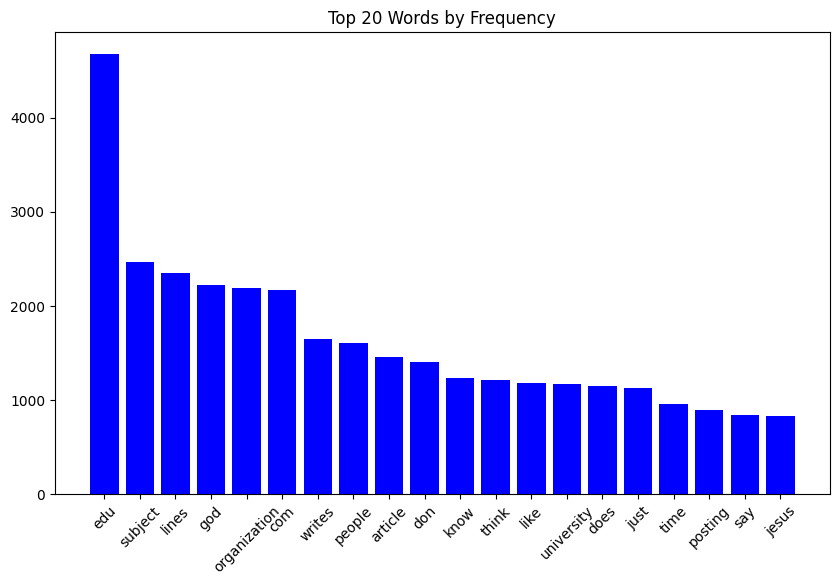

In [14]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer with stop words
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the text data
X = vectorizer.fit_transform(df['text'])

# Convert to a DataFrame
word_freq_df = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'frequency': X.toarray().sum(axis=0)})

# Sort by frequency
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

# Plot top 20 words
plt.figure(figsize=(10, 6))
plt.bar(word_freq_df['word'].head(20), word_freq_df['frequency'].head(20), color='blue')
plt.title('Top 20 Words by Frequency')
plt.xticks(rotation=45)
plt.show()


#### 3. Tokenization
Tokenization is the process of converting a text into individual words or tokens.

In [15]:
import nltk
# nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

# Tokenize the text data
df['tokens'] = df['text'].apply(word_tokenize)
df['tokens'].head()

0    [From, :, sd345, @, city.ac.uk, (, Michael, Co...
1    [From, :, ani, @, ms.uky.edu, (, Aniruddha, B....
2    [From, :, djohnson, @, cs.ucsd.edu, (, Darin, ...
3    [From, :, s0612596, @, let.rug.nl, (, M.M, ., ...
4    [From, :, stanly, @, grok11.columbiasc.ncr.com...
Name: tokens, dtype: object

#### 4. Stemming
Stemming reduces words to their root form by removing suffixes. For example, "running" becomes "run."

In [16]:
from nltk.stem import PorterStemmer

# Initialize stemmer
stemmer = PorterStemmer()

# Apply stemming
df['stemmed'] = df['tokens'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])
df['stemmed'].head()

0    [from, :, sd345, @, city.ac.uk, (, michael, co...
1    [from, :, ani, @, ms.uky.edu, (, aniruddha, b....
2    [from, :, djohnson, @, cs.ucsd.edu, (, darin, ...
3    [from, :, s0612596, @, let.rug.nl, (, m.m, ., ...
4    [from, :, stanli, @, grok11.columbiasc.ncr.com...
Name: stemmed, dtype: object

#### 5. Lemmatization
Lemmatization also reduces words to their root form, but it is more sophisticated than stemming. It considers the meaning of the word. For example, "better" becomes "good."

In [17]:
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization
df['lemmatized'] = df['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])
df['lemmatized'].head()

0    [From, :, sd345, @, city.ac.uk, (, Michael, Co...
1    [From, :, ani, @, ms.uky.edu, (, Aniruddha, B....
2    [From, :, djohnson, @, cs.ucsd.edu, (, Darin, ...
3    [From, :, s0612596, @, let.rug.nl, (, M.M, ., ...
4    [From, :, stanly, @, grok11.columbiasc.ncr.com...
Name: lemmatized, dtype: object

#### 6. Build the Bag-of-Words Model
Now that the text is preprocessed, we can create the BoW model using Scikit-Learn's CountVectorizer.

In [18]:
# Initialize CountVectorizer
bow_vectorizer = CountVectorizer(max_features=5000, stop_words='english')

# Fit and transform the text data
X_bow = bow_vectorizer.fit_transform(df['text'])

# Display the BoW model shape
print(f"BoW Model Shape: {X_bow.shape}")

BoW Model Shape: (2257, 5000)
